# Evaluation of multi-omics GRN inference methods
## Preprocessing multi-omics data
### by Jalil Nourisa

# Imports 

In [63]:
import os
import gzip
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix


import scanpy as sc
import matplotlib.pyplot as plt
import tqdm
import scipy
import seaborn as sns
import json
import anndata as ad
import warnings
import decoupler as dc

from venn import venn 

import matplotlib
matplotlib.rc('font', family='serif')
matplotlib.rc('text', usetex='false')
matplotlib.rcParams.update({'font.size': 10})

work_dir = '../../output'
kaggle_data_dir = '/beegfs/desy/user/nourisaj/openproblems_sc_perturbation/input/'
agg_type = ['T regulatory cells', 'T cells CD8+', 'T cells CD4+']


In [2]:
multiome_var_meta = pd.read_csv(f'{kaggle_data_dir}/open-problems-single-cell-perturbations/multiome_var_meta.csv')
multiome_train = pd.read_parquet(f'{kaggle_data_dir}/open-problems-single-cell-perturbations/multiome_train.parquet')
multiome_obs_meta = pd.read_csv(f'{kaggle_data_dir}/open-problems-single-cell-perturbations/multiome_obs_meta.csv')

# scRNA-seq
We use provided normalized values as X and store the counts in the layers.

### <a id='toc4_1_1_'></a>[Formatize the data](#toc0_)

In [3]:

genes_locations = multiome_var_meta[multiome_var_meta['feature_type']=='Gene Expression']['location'].values
df_mrna = multiome_train[multiome_train['location'].isin(genes_locations)].reset_index(drop=True)
# get count and normalized count
df_mrna_pivot_raw = df_mrna.pivot(index='obs_id', columns='location', values='count')
df_mrna_pivot_raw = df_mrna_pivot_raw.fillna(0)
mrna_sparse_raw = csr_matrix(df_mrna_pivot_raw.values)
# df_mrna_pivot_n = df_mrna.pivot(index='obs_id', columns='location', values='normalized_count')
# df_mrna_pivot_n = df_mrna_pivot_n.fillna(0)
# mrna_sparse_n = csr_matrix(df_mrna_pivot_n.values)

In [4]:
adata = anndata.AnnData(X=mrna_sparse_raw, 
                obs=multiome_obs_meta.set_index('obs_id'),
                var=pd.DataFrame(index=df_mrna_pivot_raw.columns)
                )
adata.shape

(25551, 22787)

### Cell numbers for different cell types

In [6]:
adata_rna = adata.copy()

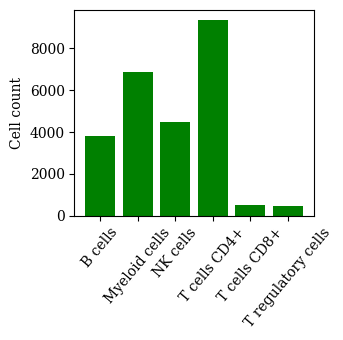

In [90]:
celltype_cellcounts = adata_rna.obs.groupby('cell_type').size()
fig, ax = plt.subplots(1,1, figsize=(3.5, 3.5))
ax.bar(celltype_cellcounts.index, celltype_cellcounts.values, color='green')
ax.tick_params(axis='x', rotation=50)
ax.set_ylabel('Cell count')
# ax.set_title('Distribution of cell count')
plt.tight_layout()
fig.savefig(f'{work_dir}/preprocess/figs/cellcount_distribution.png', dpi=300)

### Basic steps

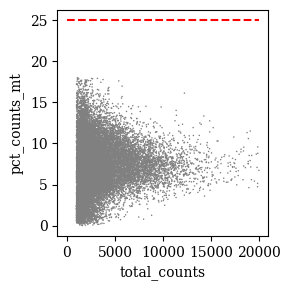

In [20]:
adata_rna.X = adata_rna.layers['counts']
adata_rna.var['mt'] = adata_rna.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
import matplotlib.pyplot as plt
mito_filter = 25
fig, axs = plt.subplots(ncols = 1, figsize = (3,3))
sc.pl.scatter(adata_rna, x='total_counts', y='pct_counts_mt', ax = axs, show=False)
#draw horizontal red lines indicating thresholds.
axs.hlines(y = mito_filter, xmin = 0, xmax = max(adata_rna.obs['total_counts']), color = 'red', ls = 'dashed')
fig.tight_layout()
plt.show()

In [ ]:
adata_rna = adata_rna[adata_rna.obs.pct_counts_mt < mito_filter, :]
adata_rna

View of AnnData object with n_obs × n_vars = 25551 × 22787
    obs: 'cell_type', 'donor_id', 'n_genes', 'louvain', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_type_colors', 'diffmap_evals', 'donor_id_colors', 'draw_graph', 'louvain', 'louvain_colors', 'louvain_sizes', 'neighbors', 'obs', 'paga', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_diffmap', 'X_draw_graph_fr', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'x_norm'
    obsp: 'connectivities', 'distances'

In [ ]:
sc.pp.filter_cells(adata_rna, min_genes=200)
sc.pp.filter_genes(adata_rna, min_cells=3)

In [22]:
# import warnings
# adata_rna.X = adata_rna.layers['x_norm']
# with warnings.catch_warnings():
#     sc.pp.filter_cells(adata_rna, min_genes=200)
#     sc.pp.filter_genes(adata_rna, min_cells=3)
#     warnings.simplefilter("ignore")
#     sc.tl.pca(adata_rna, svd_solver='arpack', use_highly_variable=False)
#     sc.pp.neighbors(adata_rna, n_neighbors=10, n_pcs=50)
#     sc.tl.umap(adata_rna)
# adata_rna

AnnData object with n_obs × n_vars = 25551 × 22787
    obs: 'cell_type', 'donor_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'x_norm'
    obsp: 'distances', 'connectivities'

### UMAP plot based on scRNA-seq 
We first plot the UMAP for all donors and individual cell types. 

In [60]:
map_names = {'donor_0':'Donor 1', 'donor_1': 'Donor 2', 'donor_2': 'Donor 3'} 
adata_rna.obs['Donor'] = adata_rna.obs.donor_id.map(map_names)
adata_rna.obs['Cell type'] = adata_rna.obs.cell_type

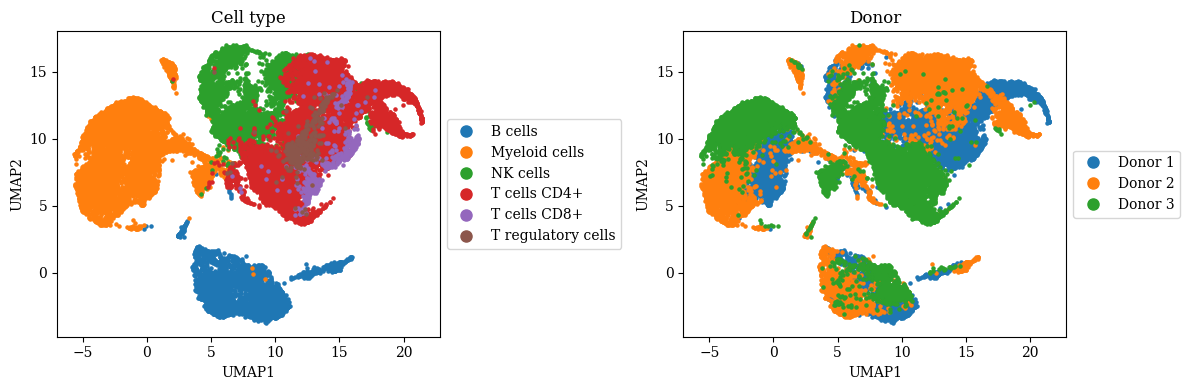

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

def cluster_plot(adata, var, ax):
    dim_data = adata.obsm['X_umap']
    legend_handles = []  
    var_unique = sorted(adata.obs[var].unique())  
    var_unique_sorted = sorted(var_unique)  
    for sub_var in var_unique_sorted:
        mask = adata.obs[var] == sub_var
        sub_data = dim_data[mask]
        scatter = ax.scatter(sub_data[:, 0], sub_data[:, 1], label=sub_var, s=5)
        legend_handles.append(plt.Line2D([0], [0], linestyle='none', marker='o', markersize=8, color=scatter.get_facecolor()[0]))

    ax.legend(handles=legend_handles, labels=var_unique_sorted, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.set_title(var)

for i_ax, var in enumerate(['Cell type', 'Donor']): 
    cluster_plot(adata_rna, var, axes[i_ax])

plt.tight_layout()

fig.savefig(f'{work_dir}/preprocess/figs/rna_cluster.png', dpi=300)
plt.show()


As can be seen, the cell types of B cells and Myeloid cells are clearly seperated while there is more overlap between other cell types. We can also see the under represenation of T cells CD8+ and T regulatory cells. These two cell types are somewhat blended with T cells CD4+. We dont see any clear seggregation for donor_id.

### Merge cell type

In [ ]:
# make it categorical
adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')
# back up obs
adata.obs['cell_type_original'] = adata.obs['cell_type']
# agg cell type
adata.obs.cell_type = adata.obs.cell_type.apply(lambda name: 'agg_type' if (name in agg_type) else name)

In [65]:
adata_rna.write(f'{work_dir}/scRNA/adata_rna.h5ad')

# scATAC-seq

### <a id='toc4_2_1_'></a>[Formatize the data](#toc0_)

In [ ]:

# extract only peaks
peaks_locations = multiome_var_meta[multiome_var_meta['feature_type']=='Peaks']['location'].values
df_peaks = multiome_train[multiome_train['location'].isin(peaks_locations)].reset_index(drop=True)
# del multiome_train

# make adata for each donor and save
def extract_count(count='count'):
    df_peaks_table = df_peaks.pivot_table(index='obs_id', columns='location', values=count)
    df_peaks_table.fillna(0, inplace=True)
    print('df_peaks table created')
    return df_peaks_table
df_peaks_table = extract_count(count='count')
# create adata
X = csr_matrix(df_peaks_table.values)
locations = df_peaks_table.columns
obs_ids = df_peaks_table.index
cell_types = []
for cell in obs_ids:
    cell_types.append(multiome_obs_meta[multiome_obs_meta['obs_id'] == cell].cell_type.values[0])
obs = pd.DataFrame(index=obs_ids)
obs['cell_type'] = cell_types
var = pd.DataFrame(index=locations)
adata = anndata.AnnData(X=X, obs=obs, var=var)
print('adata is created')
# save
adata.write(f'{work_dir}/scATAC/adata_atac.h5ad')


In [ ]:
# add donor info
adata.obs = pd.merge(adata.obs, multiome_obs_meta[['obs_id', 'donor_id']], on='obs_id', how='left')


### <a id='toc4_2_2_'></a>[UMAP plot using scATAC-seq](#toc0_)
We use agg cell types for scenic+ only. For the remaining methods, we use individual cell types. We frist plot UMAP for all donors and individual cell types. Then, we plot the same graph for donor_0 and aggregated cell types.

In [66]:
adata = anndata.read_h5ad(f'{work_dir}/scATAC/adata_atac.h5ad')

In [ ]:
adata.X = adata.layers['x_norm']
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)


In [75]:
map_names = {'donor_0':'Donor 1', 'donor_1': 'Donor 2', 'donor_2': 'Donor 3'} 
adata.obs['Donor'] = adata.obs.donor_id.map(map_names)
adata.obs['Cell type'] = adata.obs.cell_type_original

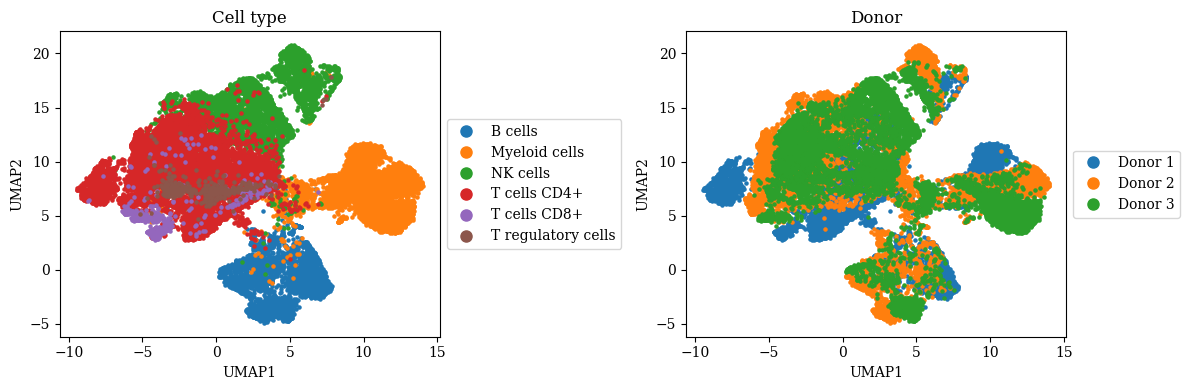

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i_ax, var in enumerate(['Cell type', 'Donor']): 
    cluster_plot(adata, var, axes[i_ax])

plt.tight_layout()

fig.savefig(f'{work_dir}/preprocess/figs/atac_cluster.png', dpi=300)
plt.show()

/root/anaconda3/envs/py10_2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/anaconda3/envs/py10_2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


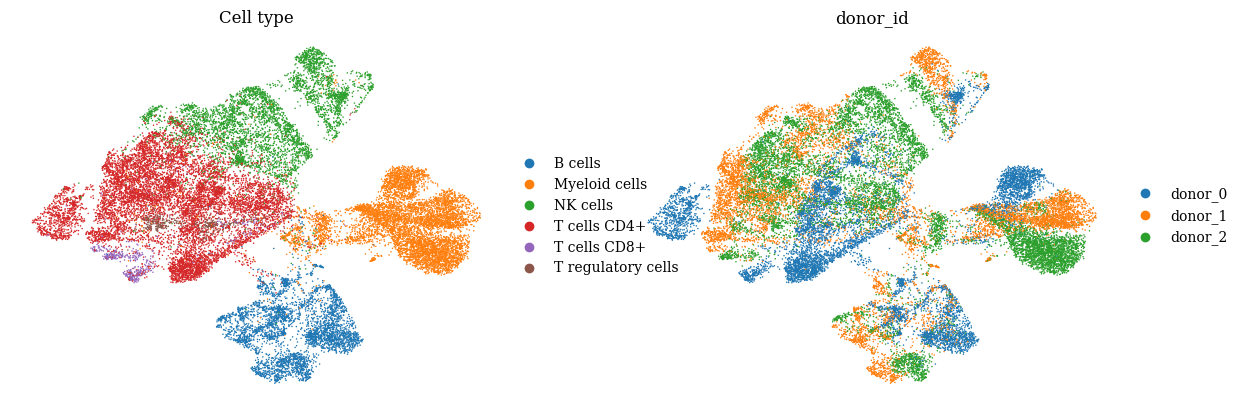

In [76]:
sc.pl.umap(adata, color=['Cell type', 'donor_id'], frameon=False)

In [ ]:
adata.X = adata.layers['counts']



In [ ]:

# make it categorical
adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')
# back up obs
adata.obs['cell_type_original'] = adata.obs['cell_type']
# agg cell type
adata.obs.cell_type = adata.obs.cell_type.apply(lambda name: 'agg_type' if (name in agg_type) else name)


In [ ]:

# save
adata.write(ff'{work_dir}/scATAC/adata_atac.h5ad')
print('adata saved')

Similar to UMAP with the RNA data, We see two cell types of T cells CD8+ and T regulatory cells are somewhat blended with T cells CD4+.